## Setup

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import numpy as np

import os
import math

# Main slim library
from tensorflow.contrib import slim

Populating the interactive namespace from numpy and matplotlib


## Display Bird Images

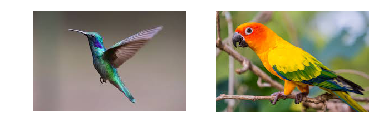

In [2]:
bird0 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_0.jpg'))
bird1 = mpimg.imread(os.path.join('..', 'Data', 'birds', 'bird_1.jpg'))
plt.figure()
plt.subplot(121)
plt.imshow(bird0)
plt.axis('off')

plt.subplot(122)
plt.imshow(bird1)
plt.axis('off')
plt.show()

## Building Graph and Predictions
Since a list of images may contain images in different sizes, we will build the graph only once and feed it multiple times.
That way, we are reusing the graph in each prediction instead of resetting and building it all over again.

In [3]:
# from slim library
import vgg_preprocessing
import imagenet
import vgg

# global
image_size  = vgg.vgg_16.default_image_size
initialized = False

def build_graph():    
    image_placeholder = tf.placeholder(tf.float32, shape=[None, None, 3])
    processed_image = vgg_preprocessing.preprocess_image(image_placeholder, image_size, image_size, is_training=False)
    processed_images  = tf.expand_dims(processed_image, 0)
    with slim.arg_scope(vgg.vgg_arg_scope()):
        logits, _ = vgg.vgg_16(processed_images, num_classes=1000, is_training=False)
    probabilities = tf.nn.softmax(logits)
    return probabilities, image_placeholder

def init_variables():
    init_fn = slim.assign_from_checkpoint_fn(
        os.path.join('.', 'vgg_16.ckpt'),
        slim.get_model_variables('vgg_16'))
    return init_fn

def predict(images, probabilities, image_placeholder, sess):
    np_probabilities = sess.run(probabilities, feed_dict={image_placeholder: images})
    return np_probabilities

def showImage(np_image_raw, np_probabilities):
    names = imagenet.create_readable_names_for_imagenet_labels()
    np_probability = np_probabilities[0, :]
    sorted_inds = [j[0] for j in sorted(enumerate(-np_probability), key=lambda x:x[1])]
    
    plt.figure()
    plt.imshow(np_image_raw.astype(np.uint8))
    plt.axis('off')
    plt.show()

    for k in range(5):
            index = sorted_inds[k]
            # Shift the index of a class name by one. 
            print('Probability %0.2f%% => [%s]' % (np_probability[index] * 100, names[index+1]))

INFO:tensorflow:Restoring parameters from .\vgg_16.ckpt


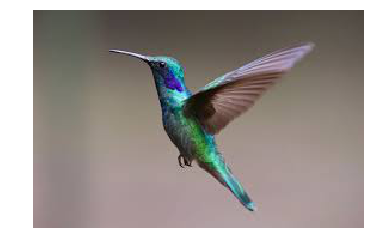

Probability 99.95% => [hummingbird]
Probability 0.04% => [jacamar]
Probability 0.01% => [bee eater]
Probability 0.00% => [black stork, Ciconia nigra]
Probability 0.00% => [red-breasted merganser, Mergus serrator]


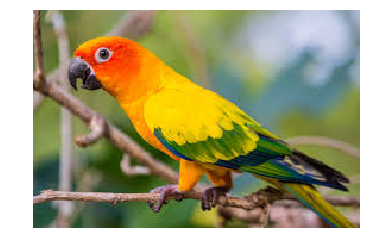

Probability 99.32% => [lorikeet]
Probability 0.46% => [macaw]
Probability 0.05% => [hummingbird]
Probability 0.04% => [bee eater]
Probability 0.04% => [jacamar]


In [4]:
if initialized == False:
    probabilities, image_placeholder = build_graph()
init_fn = init_variables()
initialized == True
sess = tf.Session()
init_fn(sess)
images = [bird0, bird1]
batch_size = len(images)
for i in range(batch_size):
    np_probabilities = predict(images[i], probabilities, image_placeholder, sess)
    showImage(images[i], np_probabilities)

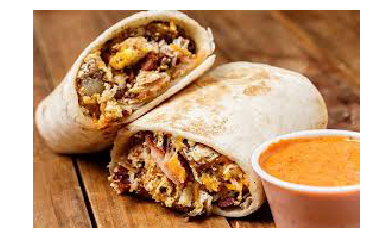

Probability 98.86% => [burrito]
Probability 0.33% => [guacamole]
Probability 0.22% => [potpie]
Probability 0.11% => [plate]
Probability 0.11% => [French loaf]


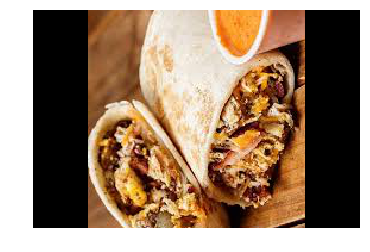

Probability 79.19% => [burrito]
Probability 2.58% => [butternut squash]
Probability 2.38% => [guacamole]
Probability 1.85% => [French loaf]
Probability 1.61% => [pizza, pizza pie]


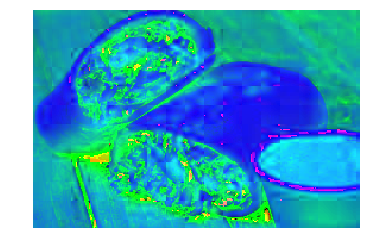

Probability 43.09% => [beaker]
Probability 25.15% => [Petri dish]
Probability 13.18% => [bubble]
Probability 6.58% => [measuring cup]
Probability 3.50% => [oscilloscope, scope, cathode-ray oscilloscope, CRO]


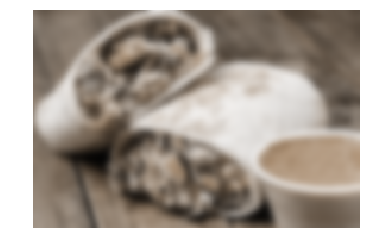

Probability 57.92% => [rock python, rock snake, Python sebae]
Probability 3.34% => [sidewinder, horned rattlesnake, Crotalus cerastes]
Probability 2.74% => [eggnog]
Probability 2.34% => [chambered nautilus, pearly nautilus, nautilus]
Probability 1.91% => [boa constrictor, Constrictor constrictor]


In [5]:
from skimage import transform
from skimage import color
from skimage import filters
    
# image and some transformations
orig_burrito          = mpimg.imread(os.path.join('..', 'Data', 'burrito.jpg'))
g_tform_burrito       = transform.rotate(orig_burrito, angle=90)*255
color_tform_burrito   = color.convert_colorspace(orig_burrito, 'RGB', 'HSV')*255
filtered_burrito      = filters.gaussian(orig_burrito, sigma=3, multichannel=False)*255

burrito_images = [orig_burrito, g_tform_burrito, color_tform_burrito, filtered_burrito]
batch_size = len(burrito_images)
for i in range(batch_size):
    np_probabilities = predict(burrito_images[i], probabilities, image_placeholder, sess)
    showImage(burrito_images[i], np_probabilities)

In [57]:
def plot_conv_weights(weights, indices):
    """Plots given filters and their response to a given feed.
    Args:
        weights: variable name
        indices: vector of indices smaller than num_filters
    """
    w = sess.run(weights)
    num_chosen_filters = len(indices)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)
    
    # Create grid of filter sub-plots.
    fig, axes = plt.subplots(1, num_chosen_filters)

    for i, ax in enumerate(axes.flat):
        if i < num_chosen_filters:
            filter_img = w[:, :, 0, indices[i]]
            ax.imshow(filter_img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='viridis')
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

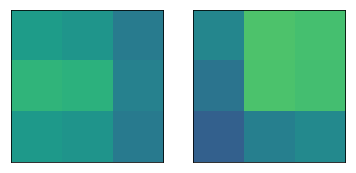

In [58]:
with tf.variable_scope('vgg_16', reuse=True):
    weights = tf.get_variable('conv1/conv1_1/weights')
    indices = [2, 4]
    images  = [g_tform_burrito, color_tform_burrito, filtered_burrito]
    plot_conv_weights(weights, indices)